In [240]:
import os
from PIL import Image
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter

In [241]:
dataset_folder = './datasets/train_zip/train'

In [242]:
data = {
    'filename': [],
    'width': [],
    'height': [],
    'class': [],
    'xmin': [],
    'ymin': [],
    'xmax': [],
    'ymax': []
}

image_files = {
    'filename': [],
    'width': [],
    'height': [],
    'object_classes': [],
}

In [255]:
def get_file_image_dimensions(file_path):
    if not os.path.isfile(file_path):
        return None, None

    with Image.open(file_path) as img:
        width, height = img.size

    return width, height

def get_xml_image_dimensions(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    return width, height

def get_image_dimensions(xml_file, image_file_path):
    width, height = get_xml_image_dimensions(xml_file)
    
    if width == 0 or height == 0:
        width, height = get_file_image_dimensions(image_file_path)
        
    return width, height

def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find('filename').text
    size = root.find('size')
    width, height = get_image_dimensions(xml_file, dataset_folder + "/" + filename)

    image_files['filename'].append(filename)
    image_files['width'].append(width)
    image_files['height'].append(height)

    file_object_classes = []
    for obj in root.iter('object'):
        obj_class = obj.find('name').text
        file_object_classes.append(obj_class)
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        data['filename'].append(filename)
        data['width'].append(width)
        data['height'].append(height)
        data['class'].append(obj_class)
        data['xmin'].append(xmin)
        data['ymin'].append(ymin)
        data['xmax'].append(xmax)
        data['ymax'].append(ymax)

    if len(set(file_object_classes)) == 1:
        image_files['object_classes'].append(file_object_classes[0])
    else:
        image_files['object_classes'].append("mixed")

In [256]:
for file in os.listdir(dataset_folder):
    if file.endswith(".xml"):
        parse_xml(os.path.join(dataset_folder, file))

In [245]:
mixed_filenames = df[df['filename'].str.contains('mixed', case=False, na=False)]['class']

In [246]:
df = pd.DataFrame(data)
image_files_df = pd.DataFrame(image_files)

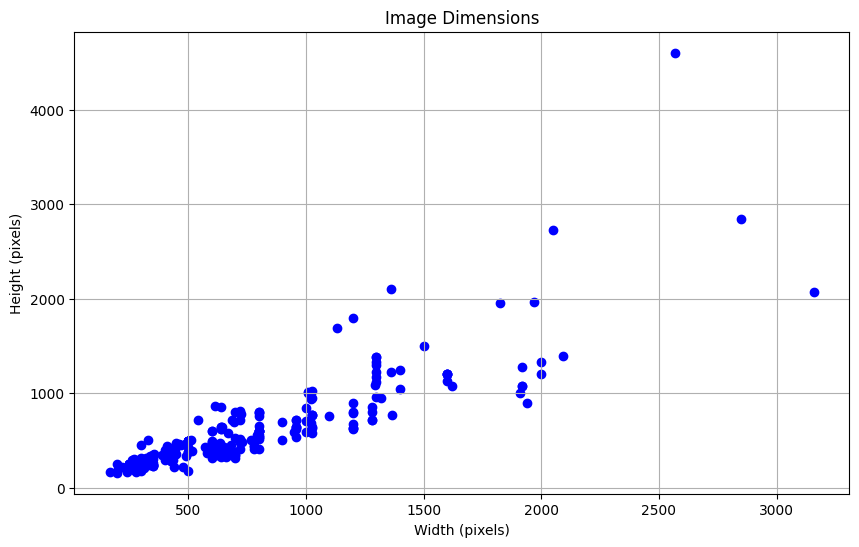

In [247]:
plt.figure(figsize=(10, 6))
plt.scatter(image_files_df['width'], image_files_df['height'], color='blue', marker='o')

plt.title('Image Dimensions')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(True)

plt.show()

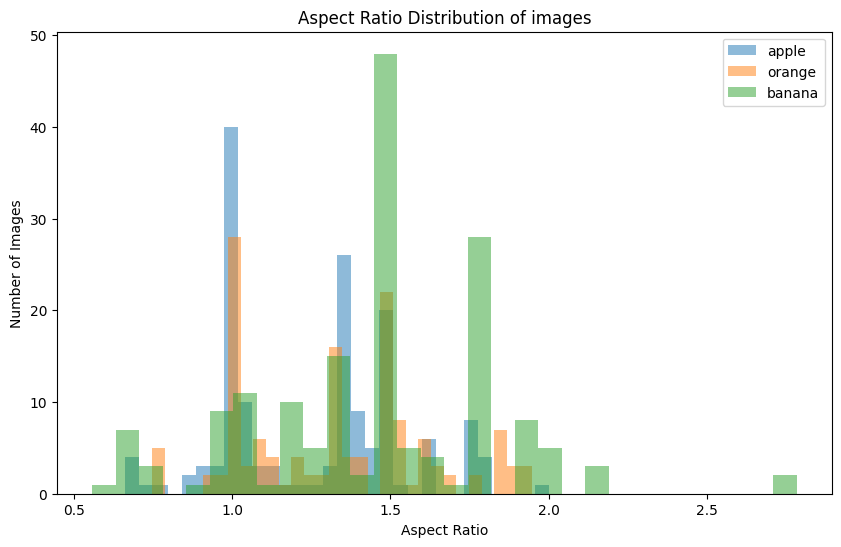

In [248]:
df['aspect_ratio'] = df['width'] / df['height']

plt.figure(figsize=(10, 6))

for obj_class in df['class'].unique():
    subset = df[df['class'] == obj_class]
    plt.hist(subset['aspect_ratio'], bins=30, alpha=0.5, label=obj_class)

plt.xlabel('Aspect Ratio')
plt.ylabel('Number of Images')
plt.title('Aspect Ratio Distribution of images')
plt.legend()
plt.show()

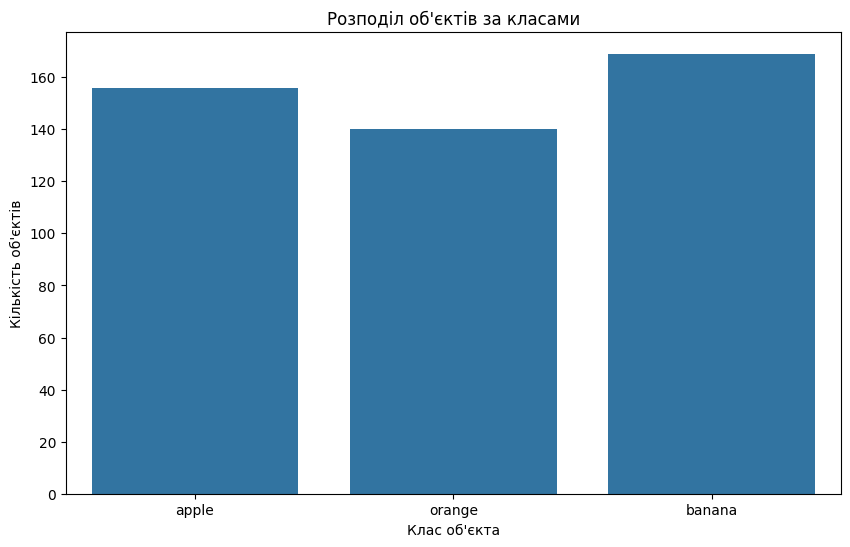

In [249]:
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=df)
plt.title('Розподіл об\'єктів за класами')
plt.xlabel('Клас об\'єкта')
plt.ylabel('Кількість об\'єктів')
plt.show()

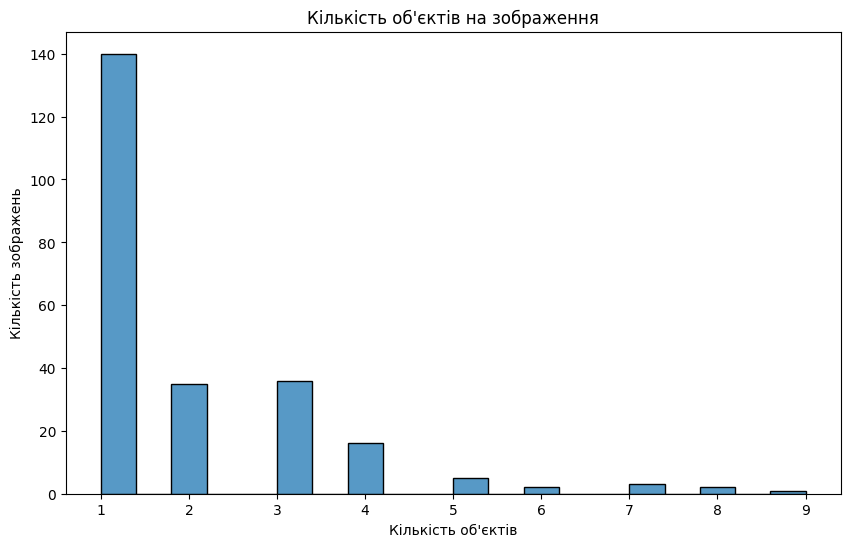

In [250]:
objects_per_image = df.groupby('filename')['class'].count().reset_index(name='object_count')

plt.figure(figsize=(10, 6))
sns.histplot(objects_per_image['object_count'], bins=20, kde=False)
plt.title('Кількість об\'єктів на зображення')
plt.xlabel('Кількість об\'єктів')
plt.ylabel('Кількість зображень')
plt.show()

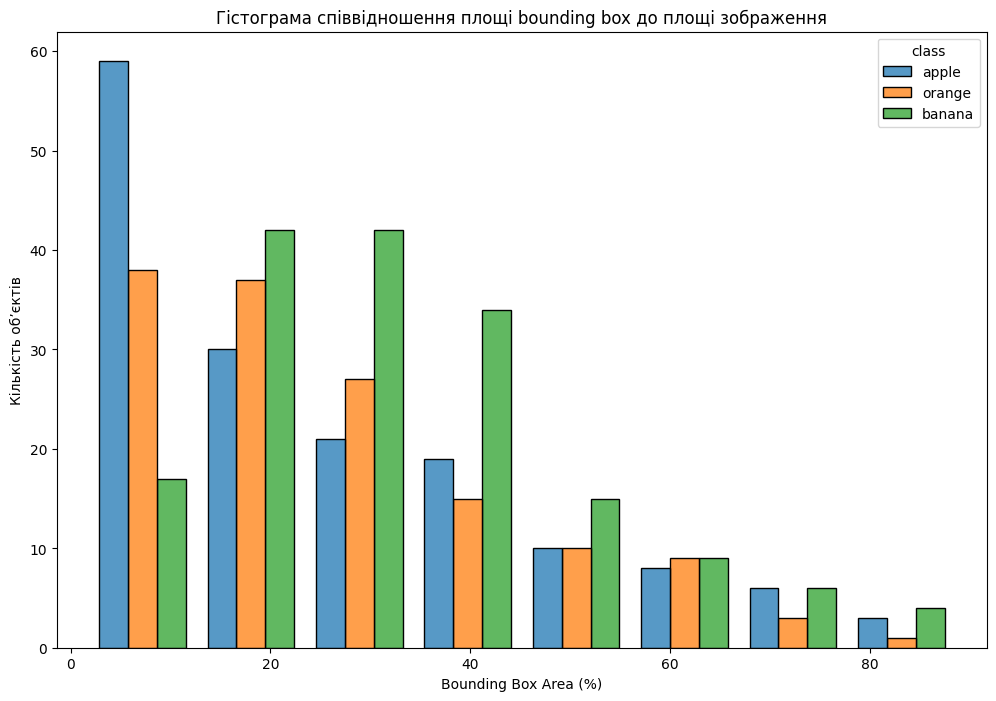

In [251]:
df['image_area'] = df['width'] * df['height']
df['bbox_area'] = (df['xmax'] - df['xmin']) * (df['ymax'] - df['ymin'])
df['bbox_percentage'] = (df['bbox_area'] / df['image_area']) * 100

plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='bbox_percentage', hue='class', multiple='dodge', bins=8, shrink=0.8)

plt.title('Гістограма співвідношення площі bounding box до площі зображення')
plt.xlabel('Bounding Box Area (%)')

plt.ylabel('Кількість обʼєктів')
plt.show()

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


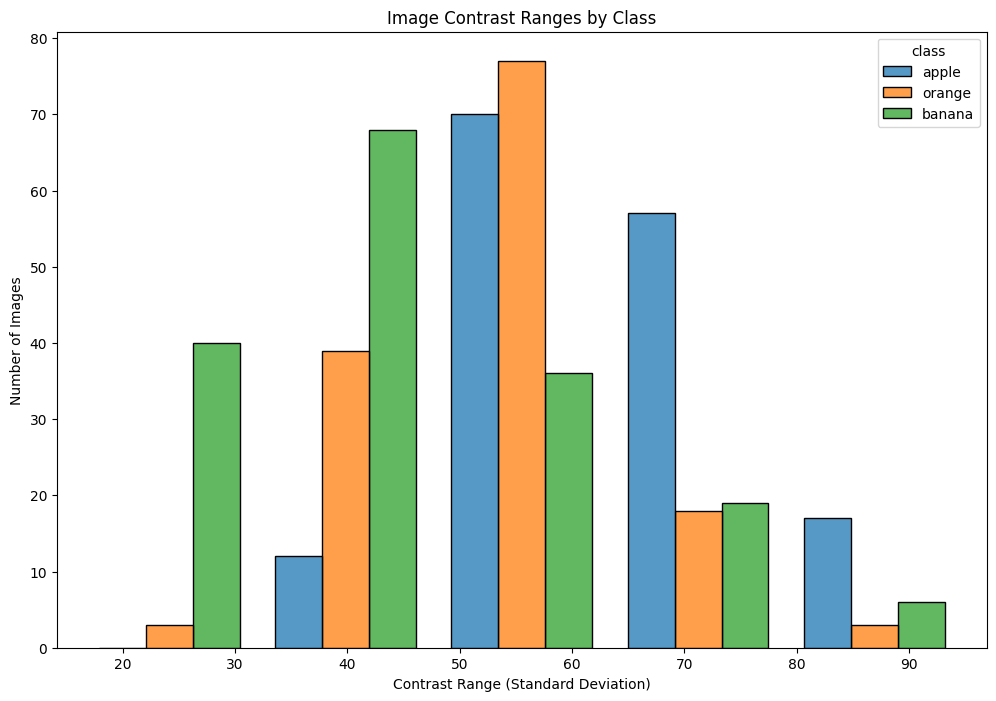

159    apple_28.jpg
282    apple_19.jpg
416     apple_1.jpg
Name: filename, dtype: object


In [252]:
def calculate_contrast(image_path):
    full_path = f"{dataset_folder}/{image_path}"
    image = cv2.imread(full_path)
    if image is None: 
        return None
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    contrast = gray_image.std()
    return contrast

df['contrast'] = df['filename'].apply(calculate_contrast)

plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='contrast', hue='class', multiple='dodge', bins=5, shrink=0.8)

plt.title('Image Contrast Ranges by Class')
plt.xlabel('Contrast Range (Standard Deviation)')
plt.ylabel('Number of Images')
plt.show()

print(df[(df['class'] == 'apple') & (df['contrast'] > 90)]['filename'])

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


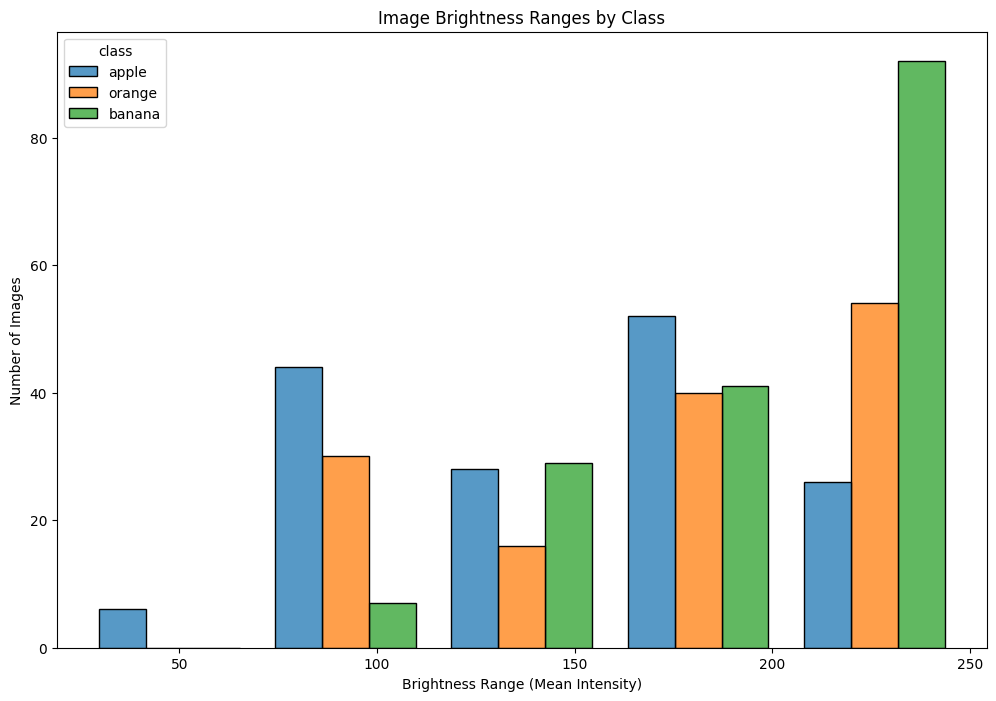

In [253]:
def calculate_brightness(image_path):
    full_path = f"{dataset_folder}/{image_path}"
    image = cv2.imread(full_path)
    if image is None: 
        return None
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness = gray_image.mean()
    return brightness

df['brightness'] = df['filename'].apply(calculate_brightness)
df = df.dropna(subset=['brightness'])

plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='brightness', hue='class', multiple='dodge', bins=5, shrink=0.8)

plt.title('Image Brightness Ranges by Class')
plt.xlabel('Brightness Range (Mean Intensity)')
plt.ylabel('Number of Images')
plt.show()

<h2>Висновки</h2>
<ul>
    <li>Перевірений датасет містить виключно true outliers.</li>
    <li>Під час препроцесінгу необхідно привести всі зображення до єдиного розміру, щоб усунути outliers, пов'язані з розмірами зображень (Image Dimensions outliers).</li>
    <li>У датасеті є 90 зображень із невизначеними значеннями ширини та висоти. Під час препроцесінгу потрібно встановити ці параметри.</li>
    <li>Модель може демонструвати погіршення навчання, якщо співвідношення сторін зображення перевищує 2.</li>
    <li>У датасеті недостатньо зображень з низькою яскравістю, що може спричинити помилки при розпізнаванні затемнених об'єктів.</li>
    <li>У датасеті недостатньо зображень яблук та апельсинів з низькою контрастністю, що може погіршити розпізнавання розмитих об'єктів цих класів.</li>
    <li>У датасеті бракує зображень апельсинів і бананів із високою контрастністю, що може викликати проблеми при розпізнаванні монохромних зображень.</li>
</ul>
